# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: driven damped pendulum

Consider a single pendulum with angle $\theta(t)$ and input $u(t)$ evolving according to:

$$ \ddot{\theta} + \frac{\mathcal{g}}{l} \sin(\theta) + \frac{\gamma}{l} \dot{\theta} = \frac{1}{ml} u\, .$$

where $m$ is mass, $l$ is length, $\gamma$ is damping and $\mathcal{g}$ is Earth's gravity.

In [1]:
using Revise
using ForwardDiff
using Optim
using RxInfer
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("./Pendulums.jl"); using .Pendulums

In [2]:
# System parameters
sys_mass = 2.0
sys_length = 0.5
sys_damping = 0.1
sys_mnoise_sd = 1e-2

0.01

In [3]:
N = 300
Δt = 0.1
tsteps = range(0.0, step=Δt, length=N)

0.0:0.1:29.9

In [4]:
# Inputs
A  = rand(10)*200 .- 100
Ω  = rand(10)*3
controls = mean([A[i]*sin.(Ω[i].*tsteps) for i = 1:10]) ./ 10;

In [5]:
init_state = [π/2, 0.0]
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     Δt=Δt)

states = zeros(2,N)
observations = zeros(N)

for k in 1:N
    states[:,k] = pendulum.state
    observations[k] = pendulum.sensor
    step!(pendulum, controls[k])
end

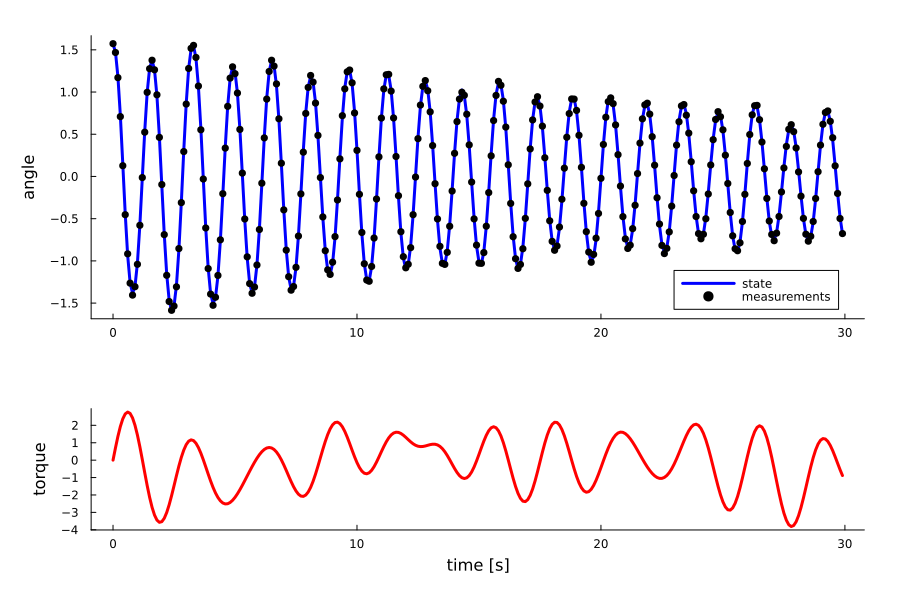

In [6]:
p1 = plot(ylabel="angle")
plot!(tsteps, states[1,:], color="blue", label="state")
scatter!(tsteps, observations, color="black", label="measurements")
p2 = plot(xlabel="time [s]", ylabel="torque")
plot!(tsteps, controls[:], color="red")
plot(p1,p2, layout=grid(2,1, heights=[0.7, 0.3]), size=(900,600))

## NARX model

In [7]:
# Polynomial degree
H = 1

# Delay order
Ly = 3
Lu = 3

# Model order
M = size(ϕ(zeros(Ly+Lu), degree=H),1);

In [8]:
# Specify prior distributions
pτ0 = GammaShapeRate(1e0, 1e-1)
pθ0 = MvNormalMeanCovariance(ones(M), 10diagm(ones(M)))

MvNormalMeanCovariance(
μ: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Σ: [10.0 0.0 … 0.0 0.0; 0.0 10.0 … 0.0 0.0; … ; 0.0 0.0 … 10.0 0.0; 0.0 0.0 … 0.0 10.0]
)


## Experiments

In [9]:
# Length of trial
N = 200
tsteps = range(0.0, step=Δt, length=N)
T = 20

# Set control properties
goal = NormalMeanVariance(3.14, 1e-4)
control_prior = 1e-4
num_iters = 10
u_lims = (-30, 30)
tlimit = 300

init_state = [0.0, 0.0];

### Mean Squared Error minimization

In [10]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     Δt=Δt)

SPendulum([0.0, 0.0], -0.010874286363678936, 0.1, 2.0, 0.5, 0.1, 0.01)

In [11]:
# Initialize beliefs
pτ = [pτ0]
pθ = [pθ0]

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  memory_actions=Lu, 
                  memory_senses=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=control_prior,
                  num_iters=num_iters)

# Preallocate
y_MSE = zeros(N)
u_MSE = zeros(N+1)

pred_m = zeros(N,T)
pred_v = zeros(N,T)
FE = zeros(num_iters, N)

policy = zeros(T)

@showprogress for k in 1:N
    
    # Act upon environment
    step!(pendulum, u_MSE[k])
    y_MSE[k] = pendulum.sensor
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_MSE[k], u_MSE[k])
    
    FE[:,k] = agent.free_energy
    push!(pθ, agent.qθ)
    push!(pτ, agent.qτ)
    
    # Optimal control
#     policy = minimizeMSE(agent, u_0=policy, time_limit=tlimit, control_lims=u_lims)
    policy = minimizeMSE(agent, time_limit=tlimit, control_lims=u_lims)
    u_MSE[k+1] = policy[1]
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


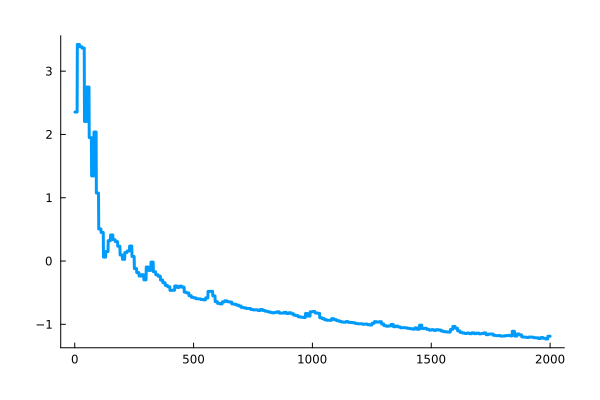

In [12]:
plot(FE[:])

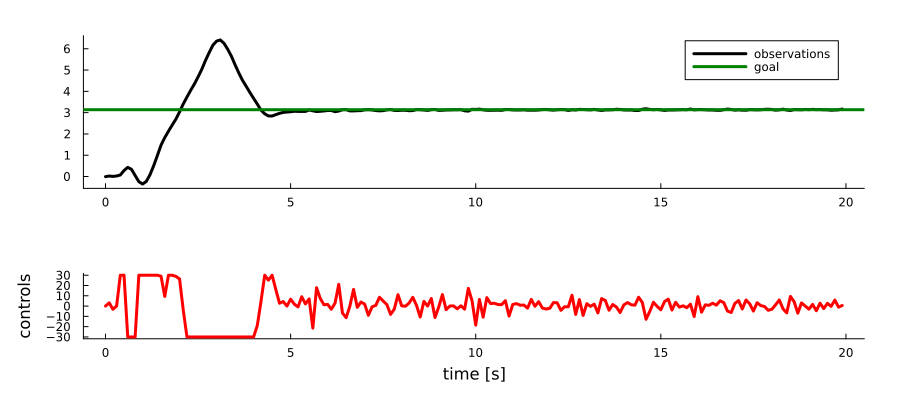

In [13]:
p1 = plot(tsteps, y_MSE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(tsteps, u_MSE[1:end-1], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [14]:
savefig("figures/NARX-MSE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-MSE-1Pendulum-trial.png"

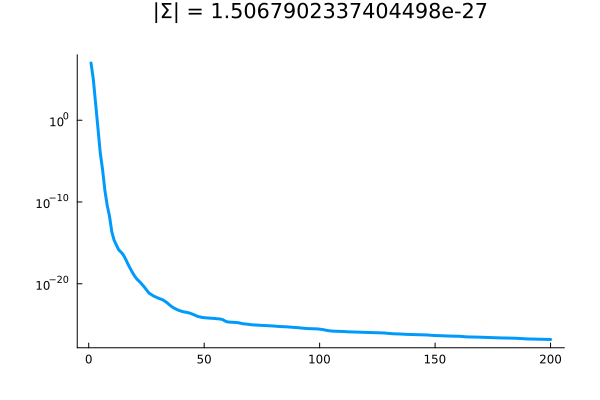

In [15]:
final_Sθ = det(cov(pθ[end]))
tSθ = [det(cov(pθ[k])) for k in 1:N]
plot(tSθ, title="|Σ| = $final_Sθ", yscale=:log10)

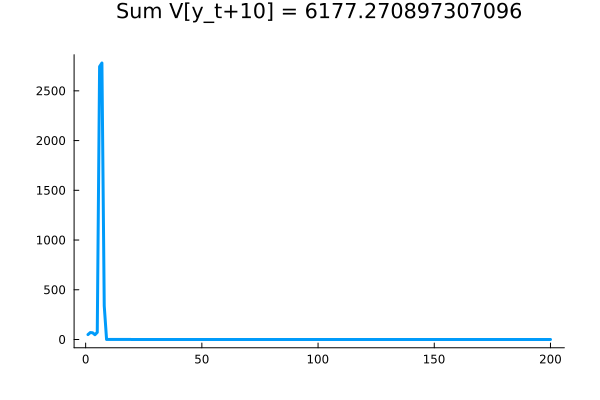

In [16]:
K = 10
sum_vy_k = sum(pred_v[:,K])
plot(pred_v[:,K], title="Sum V[y_t+$K] = $sum_vy_k")

In [17]:
limsb = [minimum(y_)*1.5, maximum(y_)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_MSE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_MSE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-MSE-1Pendulum-planning.gif", fps=24)

LoadError: UndefVarError: `y_` not defined

### Expected Free Energy minimization

In [18]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     Δt=Δt)

SPendulum([0.0, 0.0], -0.004101642579451481, 0.1, 2.0, 0.5, 0.1, 0.01)

In [26]:
# Initialize beliefs
pτ = [pτ0]
pθ = [pθ0]

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  memory_actions=Lu, 
                  memory_senses=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=control_prior,
                  num_iters=num_iters)

# Preallocate
y_EFE = zeros(N)
u_EFE = zeros(N+1)

pred_m = zeros(N,T)
pred_v = zeros(N,T)
FE = zeros(num_iters, N)

policy = zeros(T)

@showprogress for k in 1:N
    
    # Act upon environment
    step!(pendulum, u_EFE[k])
    y_EFE[k] = pendulum.sensor
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    
    FE[:,k] = agent.free_energy
    push!(pθ, agent.qθ)
    push!(pτ, agent.qτ)
    
    # Optimal control
#     policy = minimizeEFE(agent, u_0=policy, time_limit=tlimit, control_lims=u_lims)
    policy = minimizeEFE(agent, time_limit=tlimit, control_lims=u_lims)
    u_EFE[k+1] = policy[1]
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:04:57


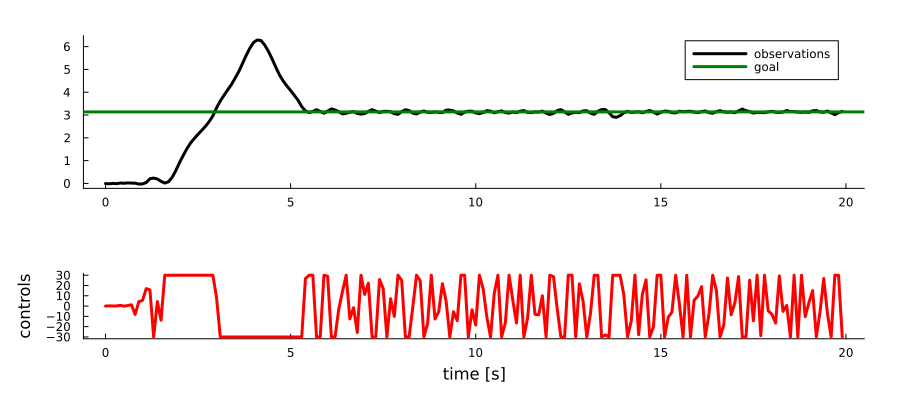

In [27]:
p1 = plot(tsteps, y_EFE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(tsteps, u_EFE[1:end-1], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [28]:
savefig("figures/NARX-EFE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-1Pendulum-trial.png"

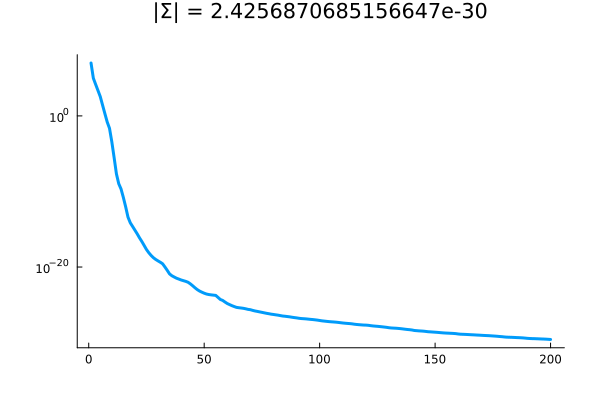

In [29]:
final_Sθ = det(cov(pθ[end]))
tSθ = [det(cov(pθ[k])) for k in 1:N]
plot(tSθ, title="|Σ| = $final_Sθ", yscale=:log10)

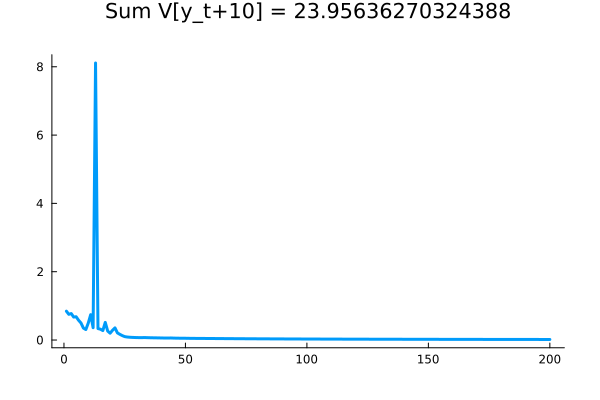

In [30]:
K = 10
sum_vy_k = sum(pred_v[:,K])
plot(pred_v[:,K], title="Sum V[y_t+$K] = $sum_vy_k")

[ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-1Pendulum-planning.gif


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/pendulum/figures/NARX-EFE-1Pendulum-planning.gif")
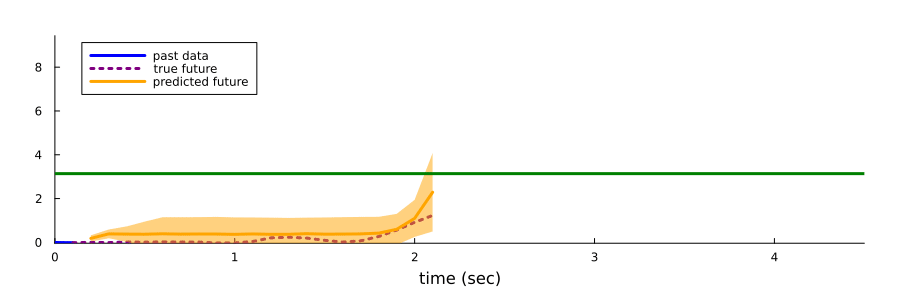

In [32]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-1Pendulum-planning.gif", fps=24)

### Comparisons

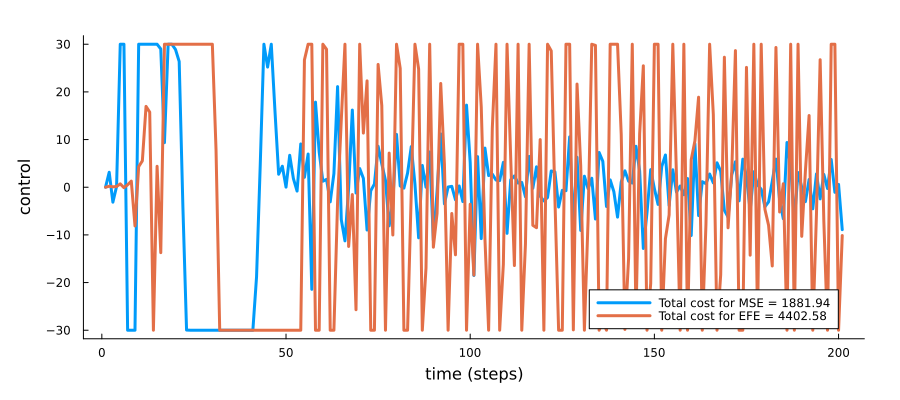

In [38]:
CC_MSE = round(sum(abs.(u_MSE)), digits=2)
CC_EFE = round(sum(abs.(u_EFE)), digits=2)

plot(xlabel="time (steps)", ylabel="control", size=(900,400))
plot!(u_MSE, label="Total cost for MSE = $CC_MSE")
plot!(u_EFE, label="Total cost for EFE = $CC_EFE")